# Классификация ирисов

In [61]:
# Импорт необходимых модулей 
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Настройки для визуализации
# Если используется темная тема - лучше текст сделать белым
TEXT_COLOR = 'black'

matplotlib.rcParams['figure.figsize'] = (15, 10)
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['axes.labelcolor'] = TEXT_COLOR
matplotlib.rcParams['xtick.color'] = TEXT_COLOR
matplotlib.rcParams['ytick.color'] = TEXT_COLOR

# Зафиксируем состояние случайных чисел
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Базовый анализ данных

In [62]:
from sklearn.datasets import load_iris

iris_data = load_iris()

feature_names = iris_data['feature_names']
df = pd.DataFrame(iris_data['data'], columns=feature_names)
species_names = iris_data['target_names']
target_idxs = iris_data['target']
df['species'] = species_names[target_idxs]

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [64]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sepal length (cm),150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal width (cm),150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal length (cm),150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal width (cm),150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


In [65]:
df.groupby('species').size()

species
setosa        50
versicolor    50
virginica     50
dtype: int64

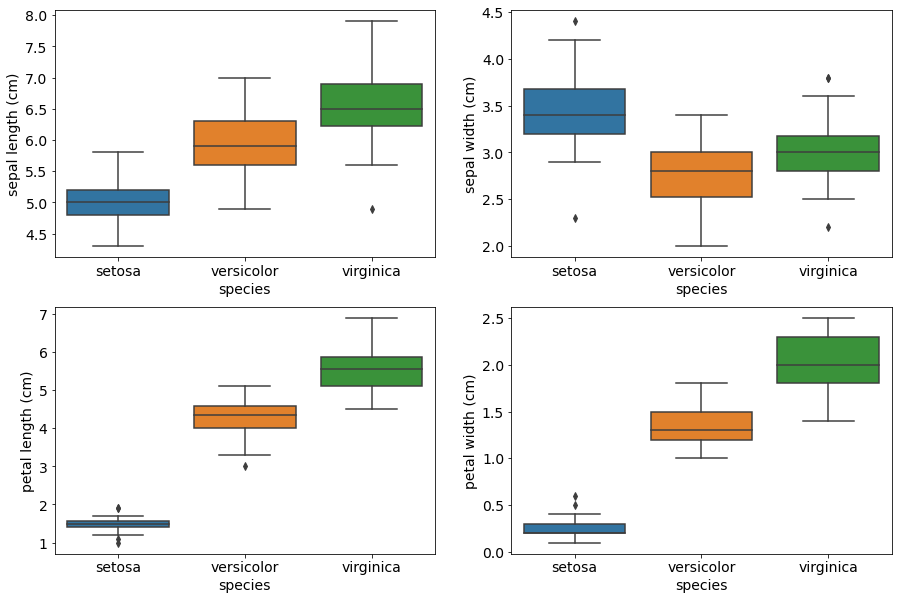

In [66]:
fig, axs = plt.subplots(2, 2)

for i, feat_name in enumerate(feature_names):
    row = i//2
    col = i%2
    sns.boxplot(x = 'species', y = feat_name, data = df, order = species_names, ax = axs[row, col]);

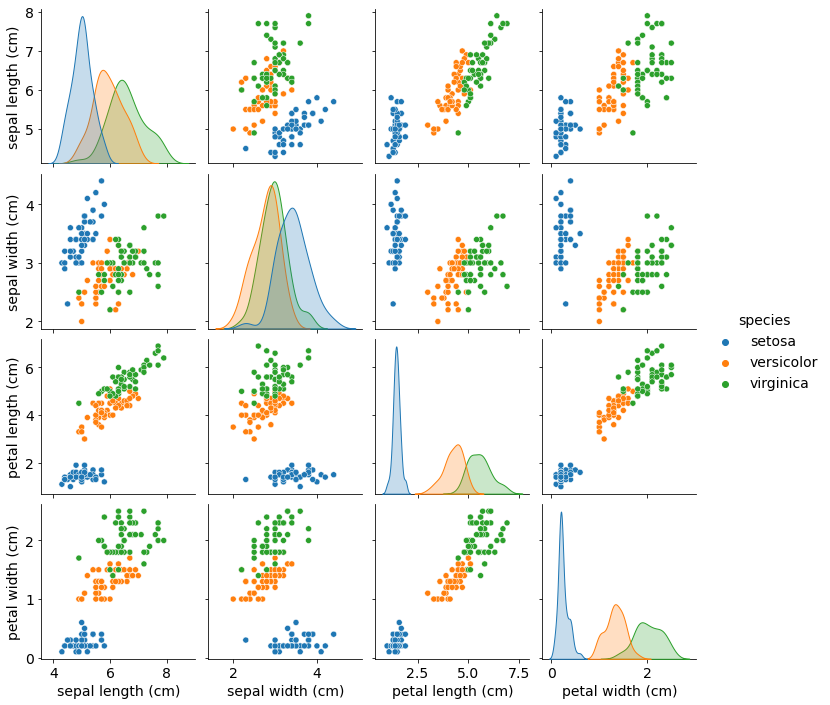

In [67]:
sns.pairplot(df, hue='species')

## Базовая модель

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, classification_report

In [69]:
TRAIN_RATIO = 0.7
X = df[feature_names]
y = target_idxs

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=TRAIN_RATIO, 
    random_state=RANDOM_STATE,
    stratify=y
)

In [70]:
logreg = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=200,
    multi_class='multinomial'
)

logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

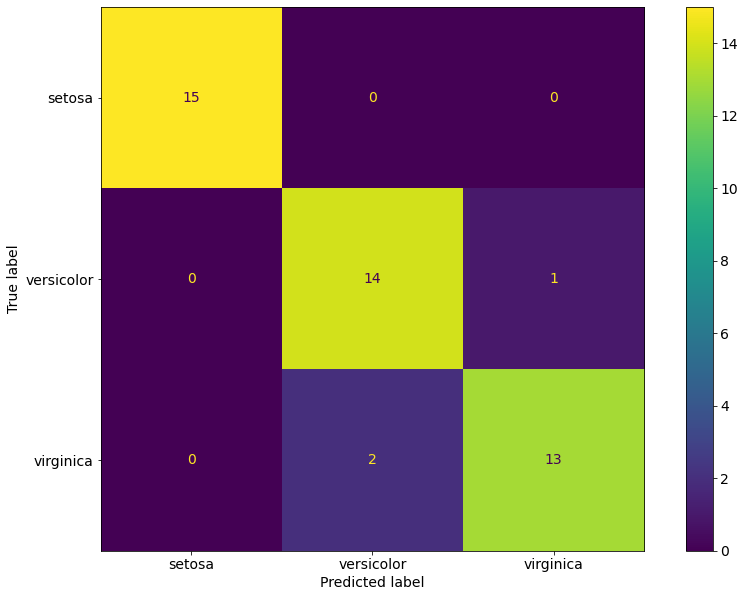

In [71]:
graph = plot_confusion_matrix(
    logreg, X_test, y_test,
    display_labels=species_names
)

In [72]:
y_pred = logreg.predict(X_test)

report = classification_report(
    y_test, y_pred, 
    target_names=species_names
)

print(report)

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.88      0.93      0.90        15
   virginica       0.93      0.87      0.90        15

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.93        45
weighted avg       0.93      0.93      0.93        45



### ROC-кривая

In [84]:
from sklearn.metrics import roc_curve, auc

In [77]:
def onehot_encode(y):
    # NOTE - для получения размера вектора воспользуйтесь максимальным значением
    #   из вектора y
    y_ohe = np.zeros((len(y), np.max(y) + 1))
    for i in range(len(y)):
      y_ohe[i][y[i]] = 1
    return y_ohe

In [81]:
y_test_ohe = onehot_encode(y_test)
y_pred_ohe = onehot_encode(y_pred)

In [82]:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_ohe[:, i], y_pred_ohe[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

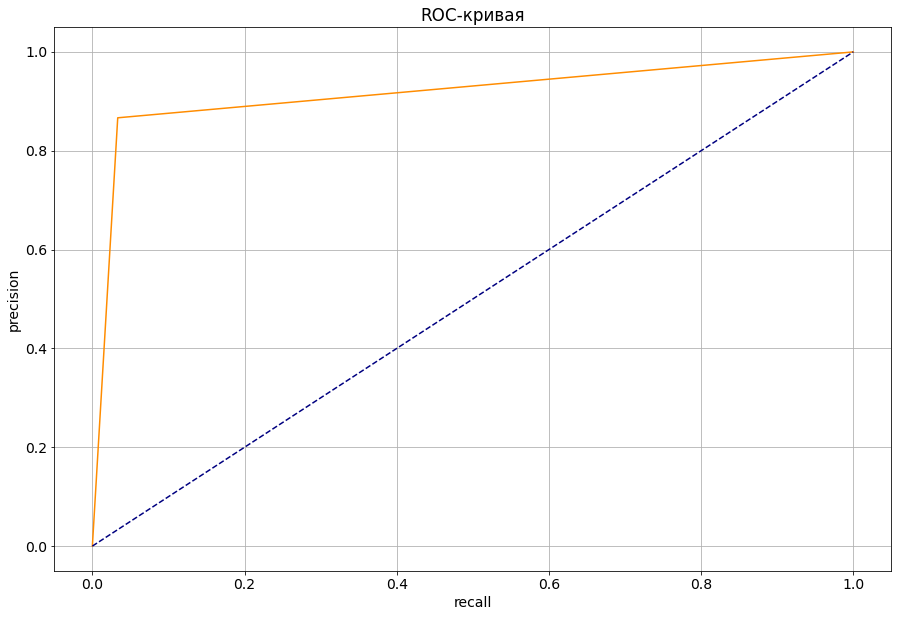

In [88]:
plt.plot(fpr[2], tpr[2], color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('ROC-кривая')
plt.grid()

## Используем StandartScaler

In [89]:
from sklearn.preprocessing import StandardScaler

In [90]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg.fit(X_train_scaled , y_train)

y_pred = logreg.predict(X_test_scaled)

In [91]:
report = classification_report(
    y_test, y_pred, 
    target_names=species_names
)

print(report)

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.87        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45



Результат: при использовании Standart Scaler точность классификации по классам versicolor и virginica уменьшилась.

## Исследуем работу модели при изменении аргумента max_iter

In [113]:
from sklearn.metrics import f1_score, precision_score

In [128]:
import warnings
warnings.filterwarnings("ignore")

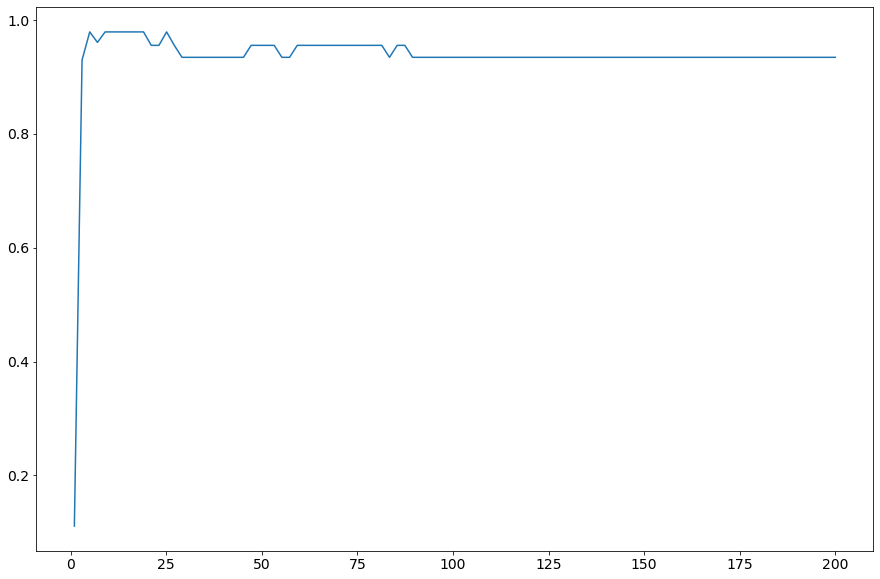

In [131]:
precision_values = []
iter_values = np.linspace(1,200, 100)
for iter in iter_values:
  logreg = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=iter,
    multi_class='multinomial'
  )
  logreg.fit(X_train, y_train)
  y_pred = logreg.predict(X_test)
  precision = precision_score(y_test, y_pred, average='macro')
  precision_values.append(precision)

plt.plot(iter_values, precision_values)
plt.show()

Как видно из графика, при наименьших количествах итераций, точность значительно падает. При увеличении числа итераций точность возрастает до максимума и остается такой. Увеличение мощности в районе числа итераций 10-80, скорее, связано с особенностями распределения данных, и может плохо отразиться на работе модели с новыми данными.

## Оценим работу модели на работе с парами признаков

### sepal length + sepal width

In [142]:
X_train_sepal = X_train[feature_names[:2]]
X_test_sepal = X_test[feature_names[:2]]

In [146]:
logreg.fit(X_train_sepal , y_train)
y_pred = logreg.predict(X_test_sepal)
report = classification_report(
    y_test, y_pred, 
    target_names=species_names
)
print(report)

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.60      0.60      0.60        15
   virginica       0.60      0.60      0.60        15

    accuracy                           0.73        45
   macro avg       0.73      0.73      0.73        45
weighted avg       0.73      0.73      0.73        45



### petal length + petal width

In [147]:
X_train_petal = X_train[feature_names[2:]]
X_test_petal = X_test[feature_names[2:]]

In [148]:
logreg.fit(X_train_petal , y_train)
y_pred = logreg.predict(X_test_petal)
report = classification_report(
    y_test, y_pred, 
    target_names=species_names
)
print(report)

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.88      0.93      0.90        15
   virginica       0.93      0.87      0.90        15

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.93        45
weighted avg       0.93      0.93      0.93        45



Полученные результаты подтверждают догадку, которую было видно из анализа данных по графикам: основную информацию для классификации предоставляют характеристики petal length и petal width.

## Кросс-валидация для разных пар признаков

In [150]:
from sklearn.model_selection import cross_val_score

In [161]:
for i in range(4):
  for j in range(i+1, 4):
    scores = cross_val_score(
      logreg,     # Модель для оценки
      X[[feature_names[i], feature_names[j]]],          # Данные для обучения
      y,          # Разметка для обучения
      cv=2,       # Количество фолдов
      scoring='f1_macro'  # Желаемая метрика
    )
    print(f'Results for the pair {feature_names[i]} and {feature_names[j]}:')
    print(f'Scores: {scores}')
    print(f'F1 (macro): {scores.mean(): 0.2f} (+/- {scores.std() * 2: 0.2f})')

Results for the pair sepal length (cm) and sepal width (cm):
Scores: [0.79991997 0.84110902]
F1 (macro):  0.82 (+/-  0.04)
Results for the pair sepal length (cm) and petal length (cm):
Scores: [0.94666667 0.9465812 ]
F1 (macro):  0.95 (+/-  0.00)
Results for the pair sepal length (cm) and petal width (cm):
Scores: [0.90535712 0.94638922]
F1 (macro):  0.93 (+/-  0.04)
Results for the pair sepal width (cm) and petal length (cm):
Scores: [0.94666667 0.93330666]
F1 (macro):  0.94 (+/-  0.01)
Results for the pair sepal width (cm) and petal width (cm):
Scores: [0.93330666 0.93397296]
F1 (macro):  0.93 (+/-  0.00)
Results for the pair petal length (cm) and petal width (cm):
Scores: [0.95998399 0.95998399]
F1 (macro):  0.96 (+/-  0.00)


Кросс-валидация подтвердила, что лучшие результаты достигаются при использовании пары petal length и petal width. Худший результат - при использовании пары sepal length и sepal width, что также подтверждает догадки по графическим представлениям данных.

## Классификация К ближайших соседей

Суть метода состоит в том, что он использует информацию о принадлежности значений из обучающей выборки определенным классам. При определении класса значения из рабочих данных используется информация о классах К ближайших соседей. Значению присваивается такой класс, которым обладает большинство его соседей.

In [162]:
from sklearn.neighbors import KNeighborsClassifier

In [164]:
classifier = KNeighborsClassifier()

classifier.fit(X_train , y_train)
y_pred = classifier.predict(X_test)
report = classification_report(
    y_test, y_pred, 
    target_names=species_names
)
print(report)

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.94      1.00      0.97        15
   virginica       1.00      0.93      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



Использование метода К соседей (с числом соседей =5 по умолчанию) позволило значительно улучшить метрики.

### Зависимость метрик от числа соседей

In [166]:
warnings.filterwarnings("default")

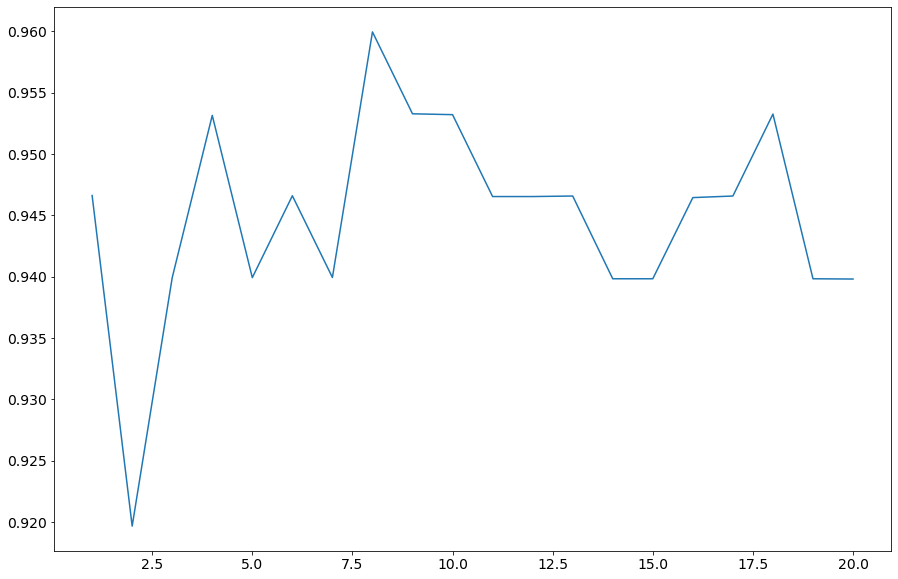

Max F1 is 0.9599572649572649 when n_neighbors = 8.0


In [172]:
f1_list = []
nums = np.linspace(1, 20, 20)
for num in nums:
  classifier = KNeighborsClassifier(n_neighbors=int(num))

  scores = cross_val_score(
    classifier,     # Модель для оценки
    X,          # Данные для обучения
    y,          # Разметка для обучения
    cv=2,       # Количество фолдов
    scoring='f1_macro'  # Желаемая метрика
  )
  f1_list.append(scores.mean())

plt.plot(nums, f1_list)
plt.show()

print(f'Max F1 is {max(f1_list)} when n_neighbors = {nums[f1_list.index(max(f1_list))]}')

Как видно из графика, четкой зависимости между качеством работы модели и числом соседей нет. В данном случае оптимальным числом соседей оказалось 8.

## Плоскости решений при различных подходах

In [174]:
from matplotlib.colors import ListedColormap

### K-соседей

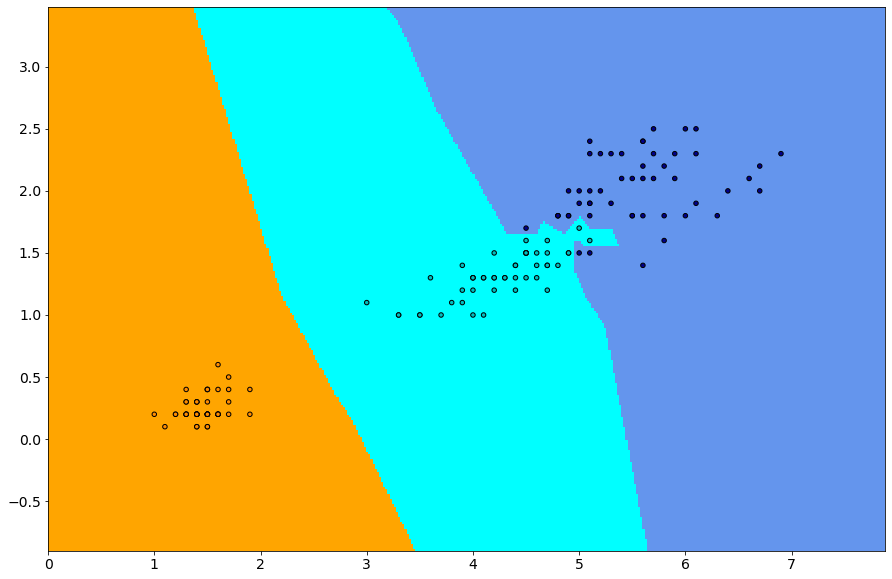

In [191]:
h = .02 
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

classifier = KNeighborsClassifier(n_neighbors=1)
X_best = iris.data[:, 2:4]
classifier.fit(X_best,y)

x_min, x_max = X_best[:, 0].min() - 1, X_best[:, 0].max() + 1
y_min, y_max = X_best[:, 1].min() - 1, X_best[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(X_best[:, 0], X_best[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

Наилучший результат получился при числе соседей =1.

/usr/local/lib/python3.6/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.6/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()


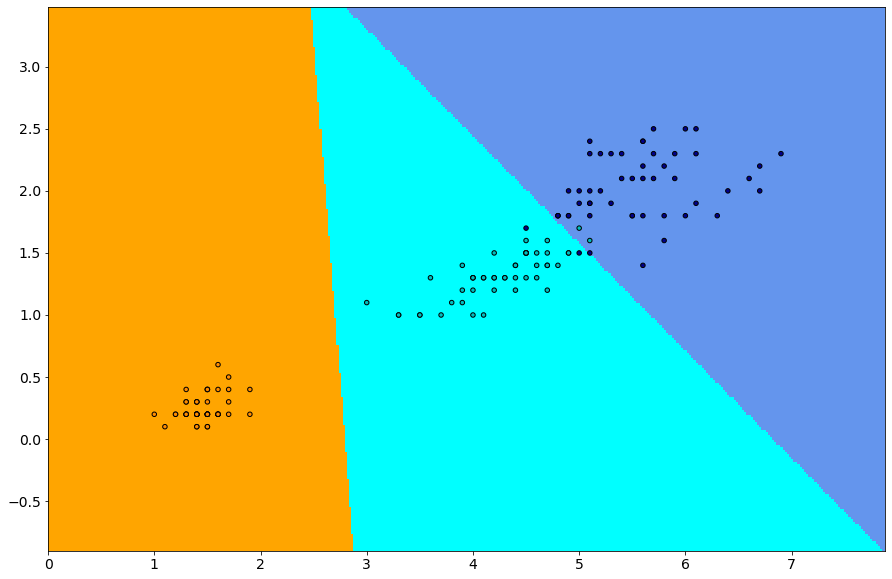

In [192]:
logreg = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=200,
    multi_class='multinomial'
)
logreg.fit(X_best,y)
x_min, x_max = X_best[:, 0].min() - 1, X_best[:, 0].max() + 1
y_min, y_max = X_best[:, 1].min() - 1, X_best[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(X_best[:, 0], X_best[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

Из графиков видно, что метод К соседей при данных настройках позволил добиться лучшей классификации.

## Вопросы



1.   Почему массив весов имеет размер 3х4, а массив смещений - 3 элемента в модели логистической регрессии? Потому что массив весов содержит веса для каждого класса по каждому элементу (3 элемента, 4 класса)
2.   В чем различия методов усреднения статистики macro, micro и weighted? Micro - глобально (все TP, FP и FN), macro - для каждого значения без учета дисбаланса данных, weighted - с учетом дисбаланса.
3.   Что означает support в отчете классификации? Число объектов, использованных при расчете.
4.   Продемонстрируйте расчет показателей recall и precision одного из классов по любой из CM. Пример расчета - после ответов.
5.   Что происходит при использовании аргумента stratify при разделении на выборки? Что будет, если не использовать данный аргумент? При его использовании данные делятся так, чтобы в тренировочной и тестовой выборке сохранялись пропорции между записями разных классов. Если не использовать - можно получить неадекватную выборку (например, в тренировочной выборке будет полностью отсутствовать один класс)
6.    В чем разницах подходов обучения модели линейной регрессии и логистичесой регрессии? При линейной регрессии достаточно поставить входным значениям в соответвтсие выходную (вещественную), а при логистической ее еще надо преобразовать в соответствие объекта определенному классу.
7.    На основе чего работает метод KNN? На основании рассмотрения классов соседей объекта (из обучающей выборки)
8.    Как влияет количество соседей на работу модели? "Сглаживает" границы областей.
9.    В чем отличие кросс-валидации от разделения на выборки обучения/валидации/теста? Для чего применяется выборка обучения? Валидации? А теста? В том, что при кросс-валидации используется несколько разных разделений на обучающую и тестову выборки. Выборка обучения - для настройки модели, валидации - для проверки ее работоспособности (на одном из фолдов), теста - для конечной проверки результирующей модели.



/usr/local/lib/python3.6/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.6/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()


Для класса 0: recall=1.0; precision=1.0
Для класса 1: recall=0.9333333333333333; precision=0.875
Для класса 2: recall=0.8666666666666667; precision=0.9285714285714286


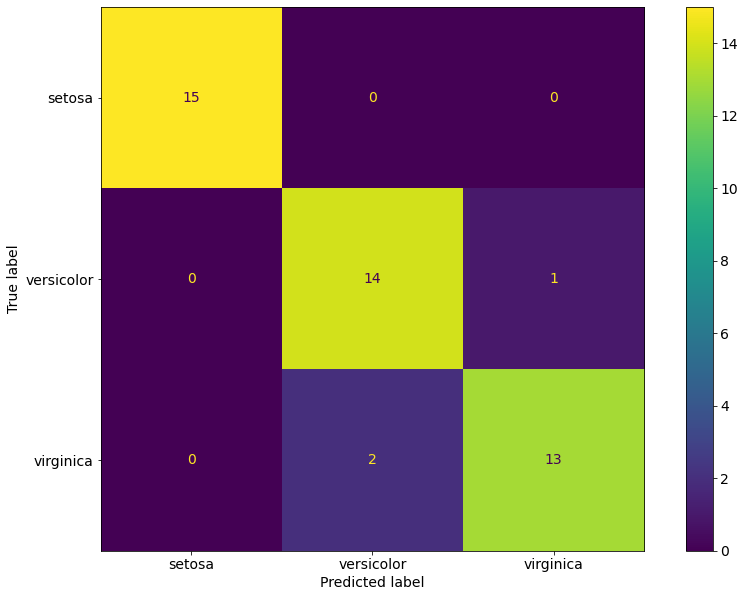

In [193]:
from sklearn.metrics import plot_confusion_matrix

logreg = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=200,
    multi_class='multinomial'
)
logreg.fit(X_train,y_train)
disp = plot_confusion_matrix(
    logreg, X_test, y_test,
    display_labels=species_names
)
for i in range(3):
  recall = disp.confusion_matrix[i,i]/(np.sum(disp.confusion_matrix[i,:]))
  precision = disp.confusion_matrix[i,i]/(np.sum(disp.confusion_matrix[:,i]))
  print(f'Для класса {i}: recall={recall}; precision={precision}')